In [4]:
import pandas as pd
import requests
import datetime
import json
import numpy as np
import seaborn as sns
from numpy import array
from numpy import hstack
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

In [32]:
augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='/Users/pratikmishra/augur/augur.config.json')
augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='/Users/pratikmishra/augur/augur.config.json')

time_series = ['code-changes','code-changes-lines','issues-active','issues-closed',
              'contributors-new','reviews','issues-new',
              'open-issues-count','reviews-accepted','reviews-declined']
              
def time_series_metrics(repo_id):
    training_days = 365
    
    base_url = 'http://{}:{}/api/unstable/repo-groups/20/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)
    begin_date = datetime.datetime(2019, 3, 31, 0, 0)#datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
    index = pd.date_range(begin_date, periods=training_days, freq='D')
    df = pd.DataFrame(index)
    df.columns = ['date']
    df['date'] = df['date'].astype(str)

    for endpoint in time_series:
        #print(endpoint)
        
        url = base_url + endpoint
        print("Hitting endpoint: " + url + "\n")
        try:
            data = requests.get(url=url).json()
            #print(data)
        except:
            data = json.loads(json.dumps(requests.get(url=url).text))

        if len(data) == 0:
            print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
            continue
                    
        if 'date' not in data[0]:
            print("Endpoint {} is not a timeseries, moving to next endpoint.\n".format(endpoint))
            continue
                
        metric_df = pd.DataFrame.from_records(data)
        metric_df['date'] = pd.to_datetime(metric_df['date']).dt.date
        metric_df['date'] = metric_df['date'].astype(str)
        extra=['repo','rg','week','year']
        for column in metric_df.columns:
            if any(x in column for x in extra):
                metric_df.drop(column,axis=1,inplace=True)
                
        df = pd.DataFrame(pd.merge(df,metric_df.loc[:,metric_df.columns],how = 'left',on = 'date'))
        metric_df.drop('date',axis=1,inplace=True)
        df.rename(columns={i :"{} _ {}".format(endpoint, i) for i in metric_df.columns }, inplace=True)
    return df

## Highly Active Repo 

#### repo_id = 25563 , git url : 

In [33]:
data = time_series_metrics(25663)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/code-changes

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-active

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-closed

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/contributors-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/open-issues-count

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews-accepted

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews-declined



In [34]:
data.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,106.0,393.0,147.0,5.0,5.0,5.0,NaN,7.0,NaN,NaN,NaN
1,2019-04-01,NaN,1109.0,647.0,NaN,11.0,2.0,2.0,4.0,6.0,NaN,1.0
2,2019-04-02,NaN,707.0,503.0,NaN,7.0,3.0,1.0,5.0,NaN,3.0,2.0
3,2019-04-03,NaN,1800.0,576.0,NaN,8.0,4.0,NaN,6.0,NaN,1.0,1.0
4,2019-04-04,NaN,793.0,409.0,2.0,6.0,3.0,1.0,13.0,NaN,1.0,1.0


In [35]:
data = data.fillna(0)

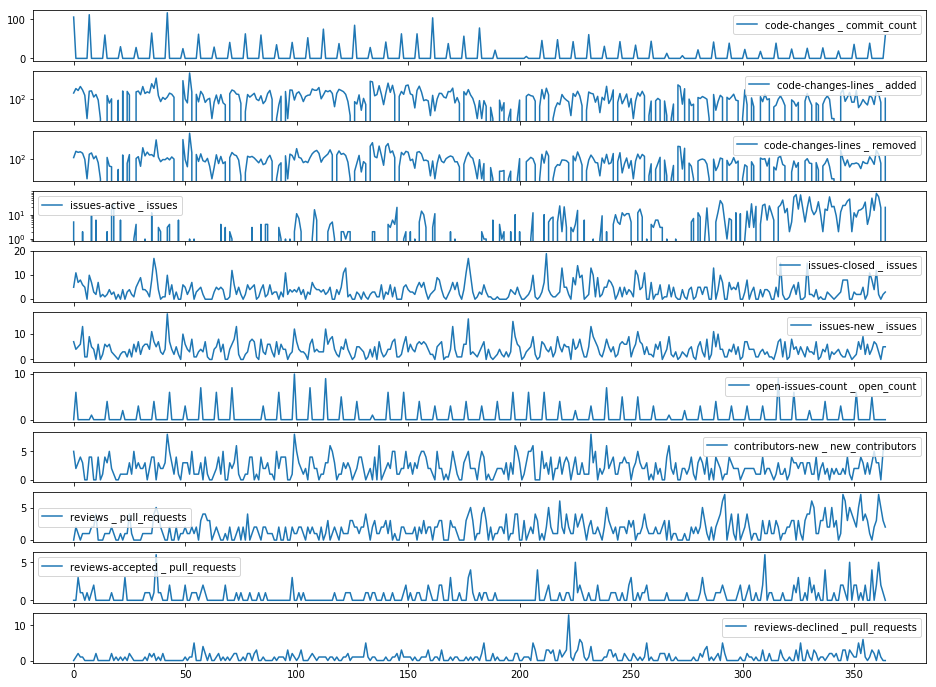

In [38]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(data.iloc[:,1])
ax[1].plot(data.iloc[:,2])
ax[2].plot(data.iloc[:,3])
ax[3].plot(data.iloc[:,4])
ax[4].plot(data.iloc[:,5])
ax[5].plot(data.iloc[:,8])
ax[6].plot(data.iloc[:,9])
ax[7].plot(data.iloc[:,6])
ax[8].plot(data.iloc[:,7])
ax[9].plot(data.iloc[:,10])
ax[10].plot(data.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [39]:
data['date']=pd.to_datetime(data['date'].astype(str), format='%Y-%m-%d')

In [41]:
data2 = data.groupby(data.date.dt.strftime('%W')).sum()

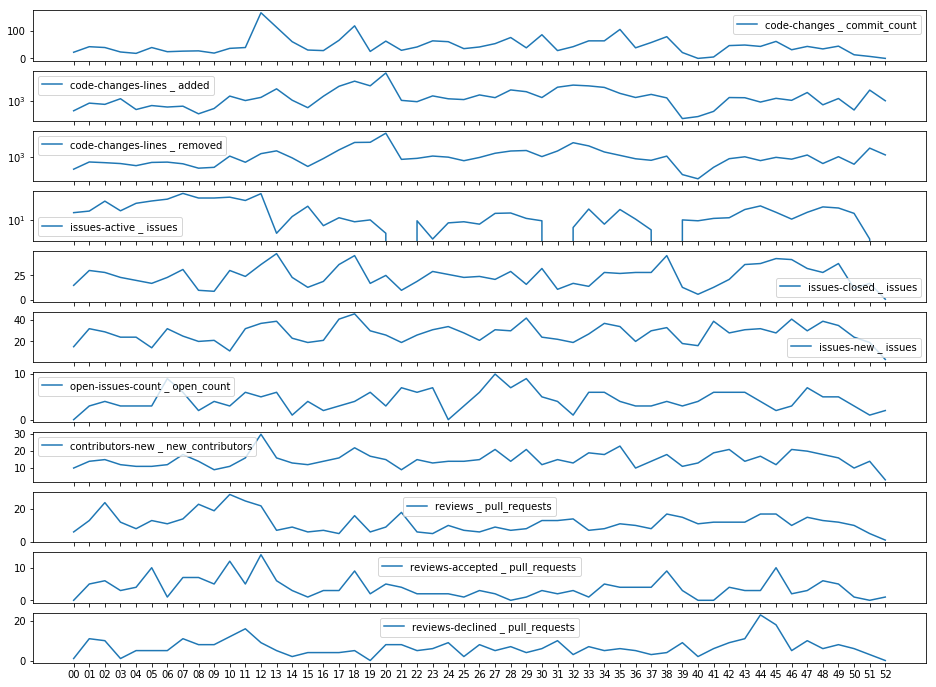

In [42]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(data2.iloc[:,0])
ax[1].plot(data2.iloc[:,1])
ax[2].plot(data2.iloc[:,2])
ax[3].plot(data2.iloc[:,3])
ax[4].plot(data2.iloc[:,4])
ax[5].plot(data2.iloc[:,7])
ax[6].plot(data2.iloc[:,8])
ax[7].plot(data2.iloc[:,5])
ax[8].plot(data2.iloc[:,6])
ax[9].plot(data2.iloc[:,9])
ax[10].plot(data2.iloc[:,10])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [43]:
data3 = data.groupby(data.date.dt.strftime('%m')).sum()

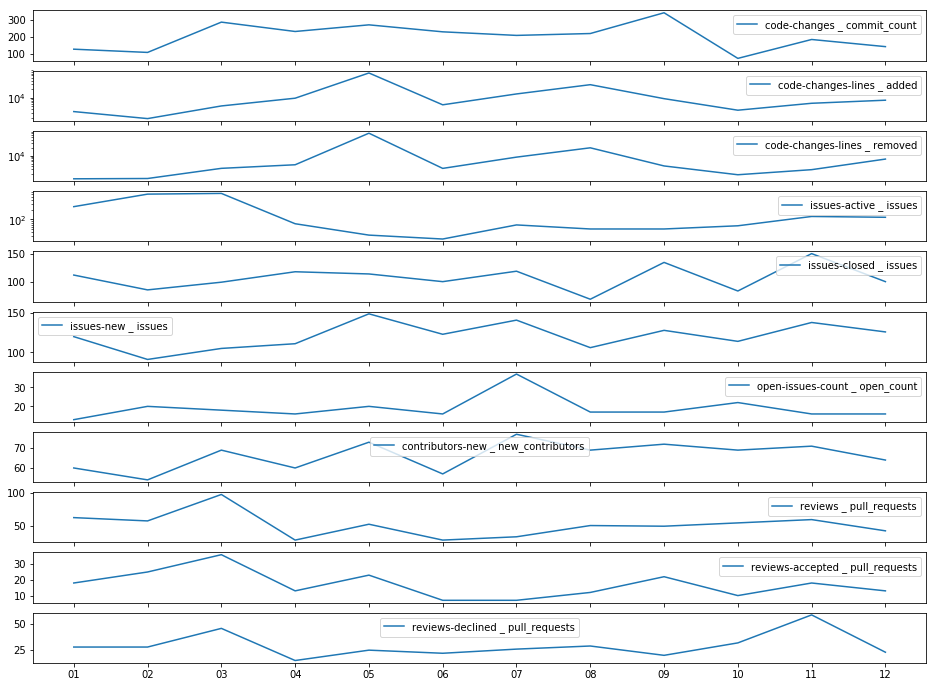

In [44]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(data3.iloc[:,0])
ax[1].plot(data3.iloc[:,1])
ax[2].plot(data3.iloc[:,2])
ax[3].plot(data3.iloc[:,3])
ax[4].plot(data3.iloc[:,4])
ax[5].plot(data3.iloc[:,7])
ax[6].plot(data3.iloc[:,8])
ax[7].plot(data3.iloc[:,5])
ax[8].plot(data3.iloc[:,6])
ax[9].plot(data3.iloc[:,9])
ax[10].plot(data3.iloc[:,10])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

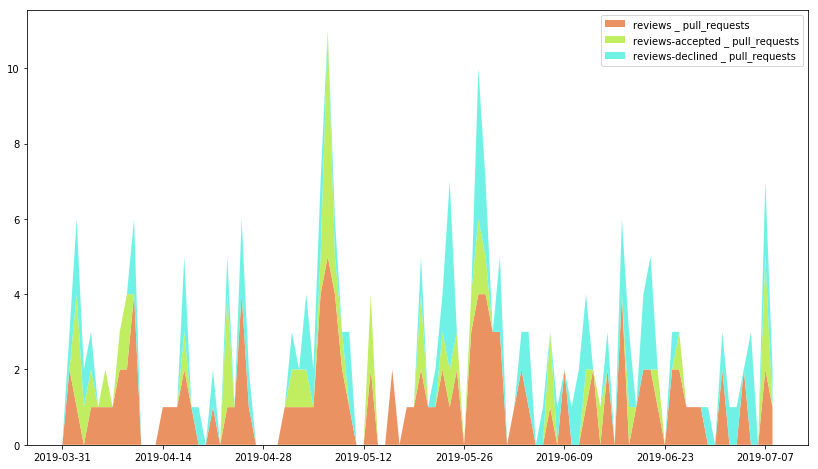

In [45]:
plt.figure(figsize=(14,8))
labels=['reviews _ pull_requests','reviews-accepted _ pull_requests','reviews-declined _ pull_requests']
colors = ['#eb9263','#c1ed61','#6ff2e5']
plt.stackplot(data[:100]['date'].values,data[:100]['reviews _ pull_requests'], data[:100]['reviews-accepted _ pull_requests'],
              data[:100]['reviews-declined _ pull_requests'],labels=labels,colors=colors)
plt.legend()

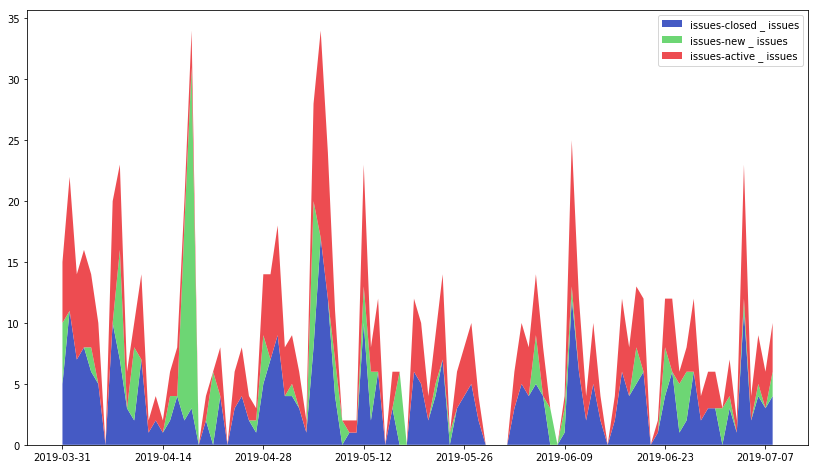

In [46]:
plt.figure(figsize=(14,8))
labels=['issues-closed _ issues','issues-new _ issues','issues-active _ issues']
colors = ['#455ac4','#6dd674','#ed4c51']
plt.stackplot(data[:100]['date'].values,data[:100]['issues-closed _ issues'], data[:100]['issues-active _ issues'],data[:100]['issues-closed _ issues'],
              labels=labels,colors=colors)
plt.legend()

In [47]:
data = data.groupby(data['date']).sum()

In [48]:
data.describe()

,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,6.591781,462.569863,352.928767,5.753425,3.517808,2.178082,1.706849,3.978082,0.624658,0.558904,0.967123
std,18.825994,2399.156258,2512.705234,11.076632,3.473263,1.683325,1.509706,3.019090,1.731716,1.002721,1.376416
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,6.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,91.000000,54.000000,1.000000,3.000000,2.000000,1.000000,4.000000,0.000000,0.000000,1.000000
75%,0.000000,309.000000,165.000000,6.000000,5.000000,3.000000,2.000000,6.000000,0.000000,1.000000,1.000000
max,117.000000,42297.000000,45525.000000,75.000000,19.000000,8.000000,7.000000,18.000000,10.000000,6.000000,13.000000


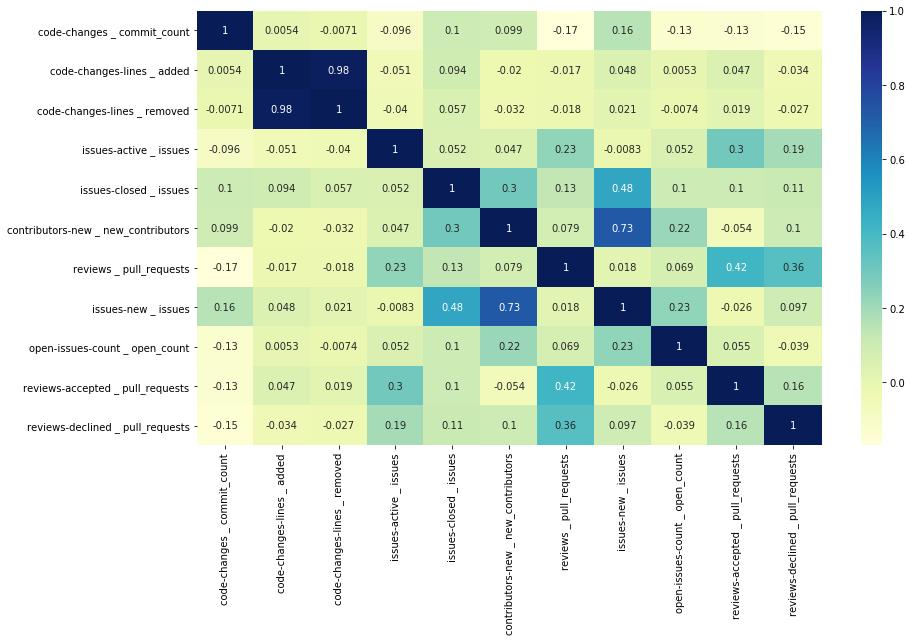

In [49]:
plt.figure(figsize=(14,8))
sns.heatmap(data.corr(), cmap="YlGnBu",annot=True)

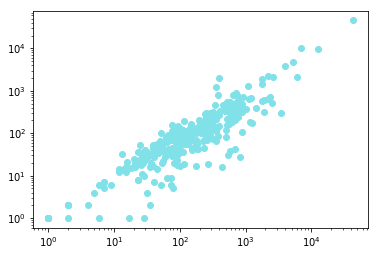

In [50]:
fig,ax=plt.subplots()
labels = ['code-changes-lines _ added','code-changes-lines _ removed']
colors = ['#80e1e8','#8182e6']
ax.plot(data['code-changes-lines _ added'],data['code-changes-lines _ removed'],'o',label=labels,color = '#80e1e8')

ax.set_yscale('log')
ax.set_xscale('log')

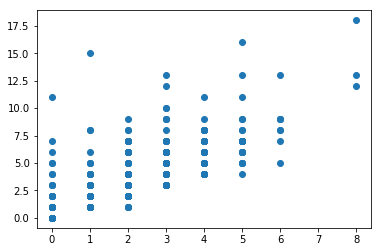

In [51]:
fig,ax=plt.subplots()
ax.plot(data['contributors-new _ new_contributors'],data['issues-new _ issues'],'o')


## Moderately Active Repo

#### repo_id = 25797   git url  : https://github.com/Spring-projects/spring-session

In [52]:
df = time_series_metrics(25797)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/code-changes

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/issues-active

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/issues-closed

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/contributors-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/reviews

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/open-issues-count

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/reviews-accepted

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/reviews-declined



In [53]:
df.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,6.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN
1,2019-04-01,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,1.0,10.0,3.0
2,2019-04-02,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN
3,2019-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df = df.fillna(0)

In [56]:
df['date']=pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d')

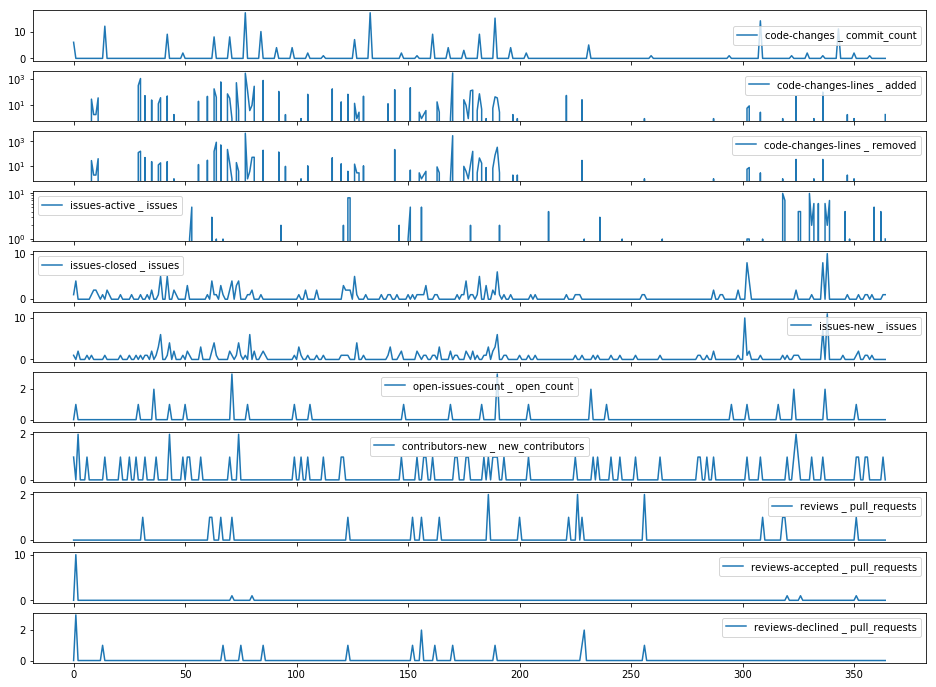

In [57]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df.iloc[:,1])
ax[1].plot(df.iloc[:,2])
ax[2].plot(df.iloc[:,3])
ax[3].plot(df.iloc[:,4])
ax[4].plot(df.iloc[:,5])
ax[5].plot(df.iloc[:,8])
ax[6].plot(df.iloc[:,9])
ax[7].plot(df.iloc[:,6])
ax[8].plot(df.iloc[:,7])
ax[9].plot(df.iloc[:,10])
ax[10].plot(df.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [58]:
df2 = df.groupby(df.date.dt.strftime('%W')).sum()

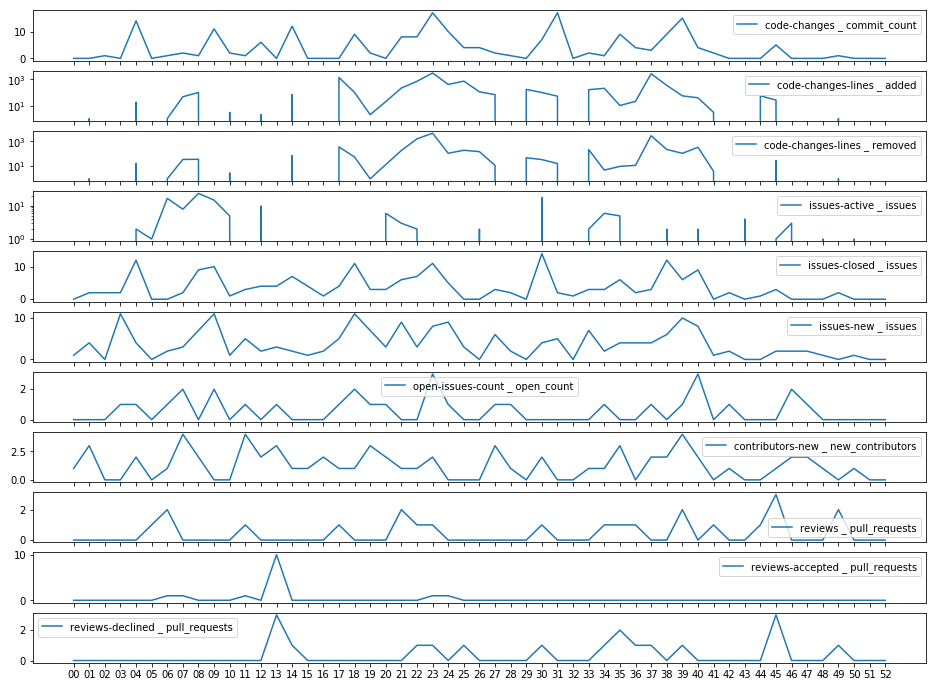

In [59]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df2.iloc[:,0])
ax[1].plot(df2.iloc[:,1])
ax[2].plot(df2.iloc[:,2])
ax[3].plot(df2.iloc[:,3])
ax[4].plot(df2.iloc[:,4])
ax[5].plot(df2.iloc[:,7])
ax[6].plot(df2.iloc[:,8])
ax[7].plot(df2.iloc[:,5])
ax[8].plot(df2.iloc[:,6])
ax[9].plot(df2.iloc[:,9])
ax[10].plot(df2.iloc[:,10])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [60]:
df3 = df.groupby(df.date.dt.strftime('%m')).sum()

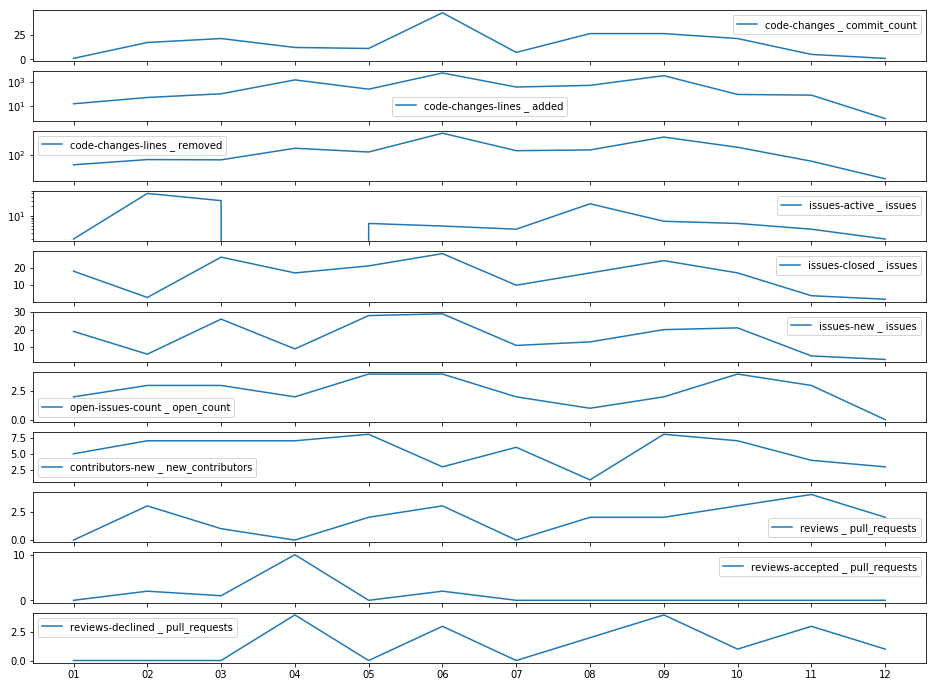

In [61]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df3.iloc[:,0])
ax[1].plot(df3.iloc[:,1])
ax[2].plot(df3.iloc[:,2])
ax[3].plot(df3.iloc[:,3])
ax[4].plot(df3.iloc[:,4])
ax[5].plot(df3.iloc[:,7])
ax[6].plot(df3.iloc[:,8])
ax[7].plot(df3.iloc[:,5])
ax[8].plot(df3.iloc[:,6])
ax[9].plot(df3.iloc[:,9])
ax[10].plot(df3.iloc[:,10])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

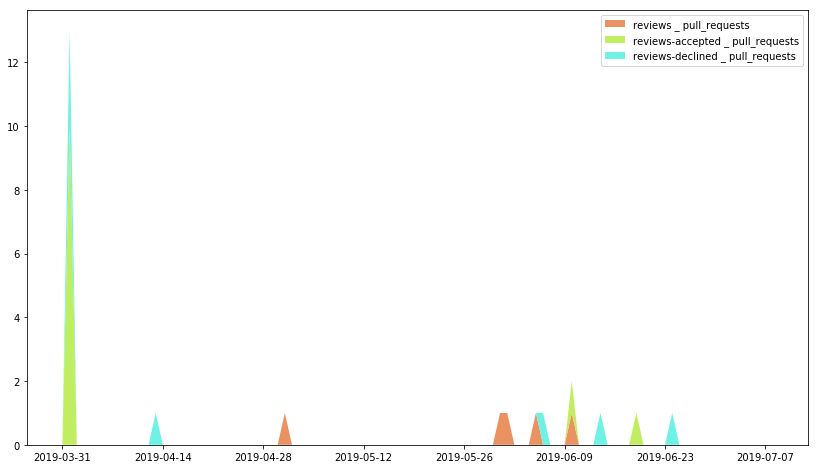

In [62]:
plt.figure(figsize=(14,8))
labels=['reviews _ pull_requests','reviews-accepted _ pull_requests','reviews-declined _ pull_requests']
colors = ['#eb9263','#c1ed61','#6ff2e5']
plt.stackplot(df[:100]['date'].values,df[:100]['reviews _ pull_requests'], df[:100]['reviews-accepted _ pull_requests'],
              df[:100]['reviews-declined _ pull_requests'],labels=labels,colors=colors)
plt.legend()

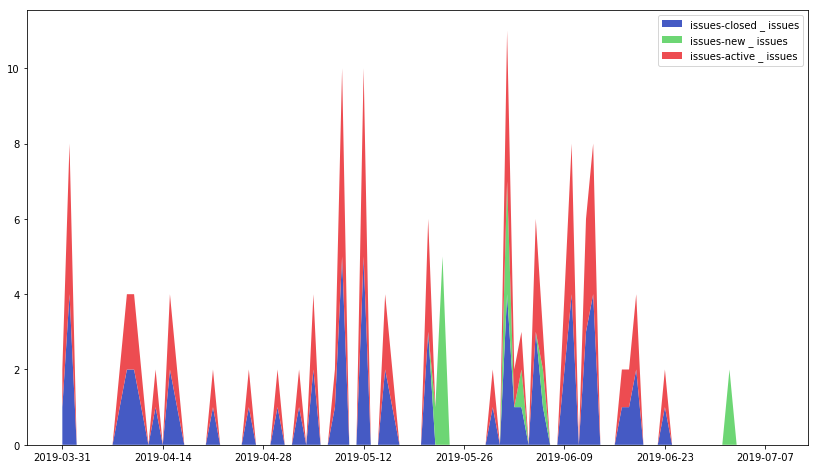

In [63]:
plt.figure(figsize=(14,8))
labels=['issues-closed _ issues','issues-new _ issues','issues-active _ issues']
colors = ['#455ac4','#6dd674','#ed4c51']
plt.stackplot(df[:100]['date'].values,df[:100]['issues-closed _ issues'], df[:100]['issues-active _ issues'],df[:100]['issues-closed _ issues'],
              labels=labels,colors=colors)
plt.legend()

In [65]:
df = df.groupby(df['date']).sum()

In [66]:
df.describe()

,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.534247,30.408219,31.465753,0.383562,0.512329,0.180822,0.060274,0.520548,0.082192,0.041096,0.049315
std,2.251265,211.009428,289.569901,1.404762,1.221594,0.412929,0.270703,1.225973,0.361370,0.535507,0.272918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,17.000000,2688.000000,4595.000000,10.000000,10.000000,2.000000,2.000000,11.000000,3.000000,10.000000,3.000000


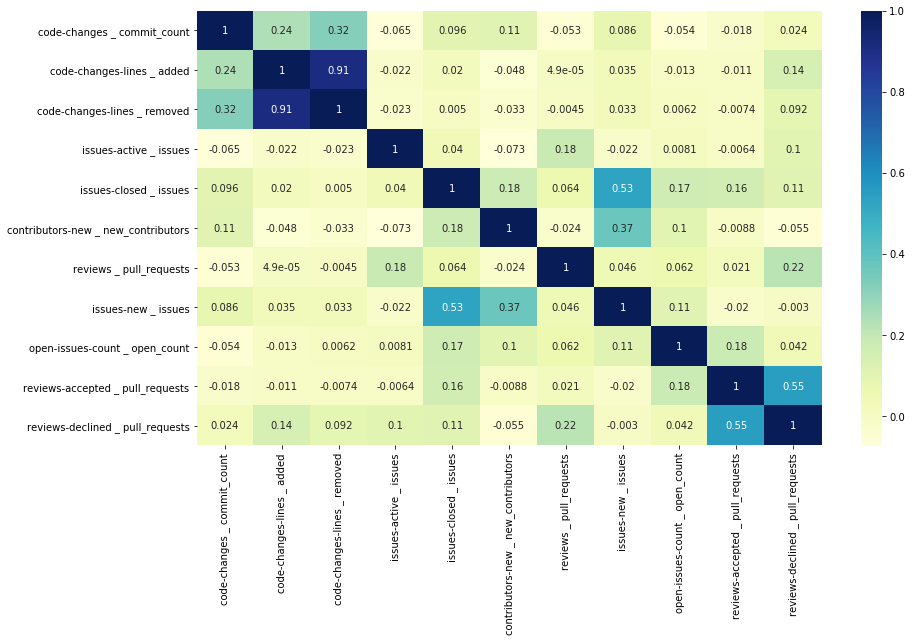

In [67]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), cmap="YlGnBu",annot=True)

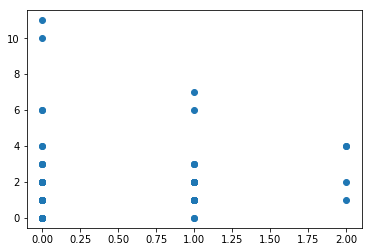

In [68]:
fig,ax=plt.subplots()
ax.plot(df['contributors-new _ new_contributors'],df['issues-new _ issues'],'o')

## Less Active Repo

#### repo_id = 30001 git url : https://github.com/projectcontour/gimbal

In [69]:
df_rame = time_series_metrics(30001)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/code-changes

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/issues-active

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/issues-closed

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/contributors-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/reviews

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/open-issues-count

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/reviews-accepted

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/reviews-declined



In [71]:
df_frame = df_frame.fillna(0)

In [72]:
df_frame.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-04-02,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2019-04-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
df_frame['date']=pd.to_datetime(df_frame['date'].astype(str), format='%Y-%m-%d')

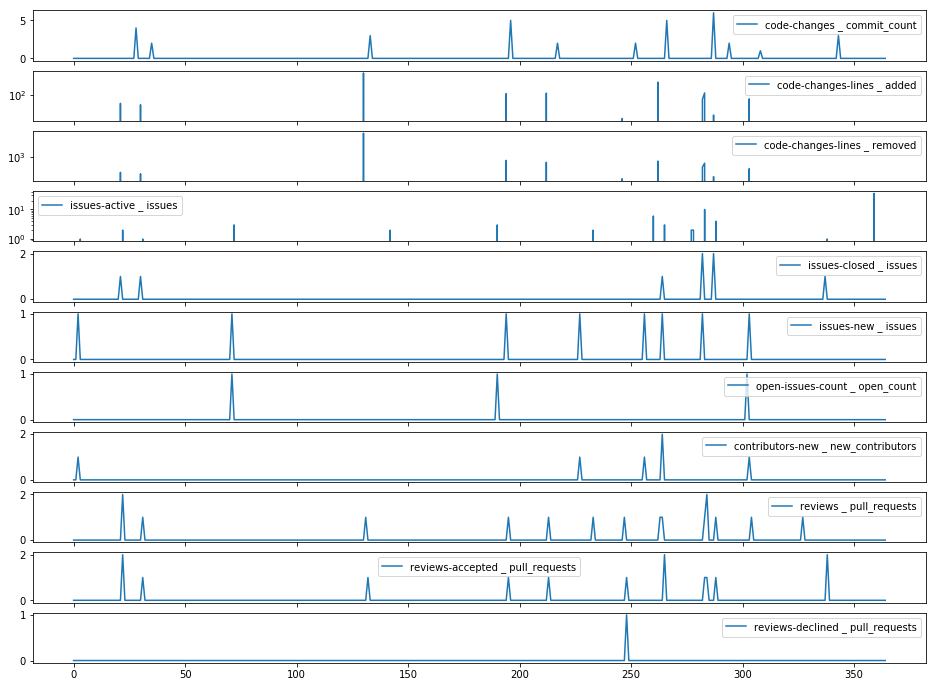

In [74]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df_frame.iloc[:,1])
ax[1].plot(df_frame.iloc[:,2])
ax[2].plot(df_frame.iloc[:,3])
ax[3].plot(df_frame.iloc[:,4])
ax[4].plot(df_frame.iloc[:,5])
ax[5].plot(df_frame.iloc[:,8])
ax[6].plot(df_frame.iloc[:,9])
ax[7].plot(df_frame.iloc[:,6])
ax[8].plot(df_frame.iloc[:,7])
ax[9].plot(df_frame.iloc[:,10])
ax[10].plot(df_frame.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [75]:
df_frame2 = df_frame.groupby(df_frame.date.dt.strftime('%W')).sum()

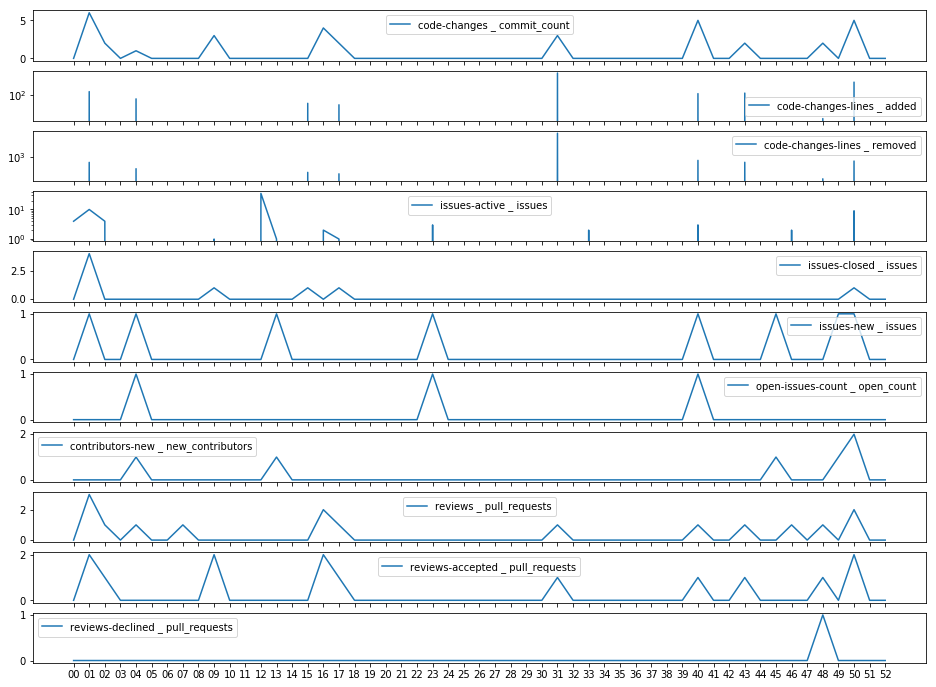

In [77]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df_frame2.iloc[:,0])
ax[1].plot(df_frame2.iloc[:,1])
ax[2].plot(df_frame2.iloc[:,2])
ax[3].plot(df_frame2.iloc[:,3])
ax[4].plot(df_frame2.iloc[:,4])
ax[5].plot(df_frame2.iloc[:,7])
ax[6].plot(df_frame2.iloc[:,8])
ax[7].plot(df_frame2.iloc[:,5])
ax[8].plot(df_frame2.iloc[:,6])
ax[9].plot(df_frame2.iloc[:,9])
ax[10].plot(df_frame2.iloc[:,10])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [78]:
df_frame3 = df_frame.groupby(df_frame.date.dt.strftime('%m')).sum()

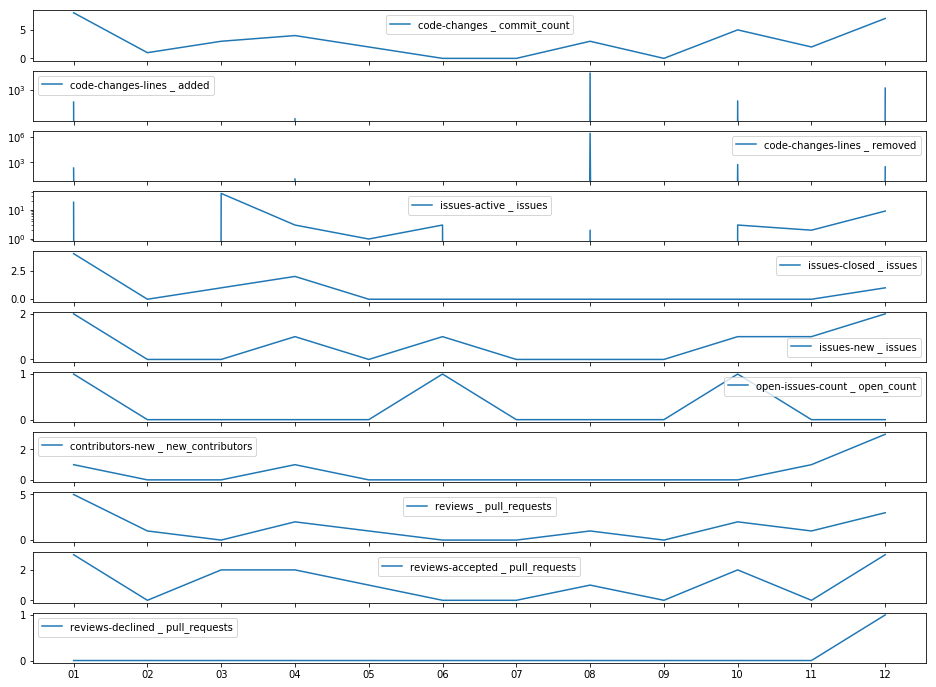

In [79]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df_frame3.iloc[:,0])
ax[1].plot(df_frame3.iloc[:,1])
ax[2].plot(df_frame3.iloc[:,2])
ax[3].plot(df_frame3.iloc[:,3])
ax[4].plot(df_frame3.iloc[:,4])
ax[5].plot(df_frame3.iloc[:,7])
ax[6].plot(df_frame3.iloc[:,8])
ax[7].plot(df_frame3.iloc[:,5])
ax[8].plot(df_frame3.iloc[:,6])
ax[9].plot(df_frame3.iloc[:,9])
ax[10].plot(df_frame3.iloc[:,10])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

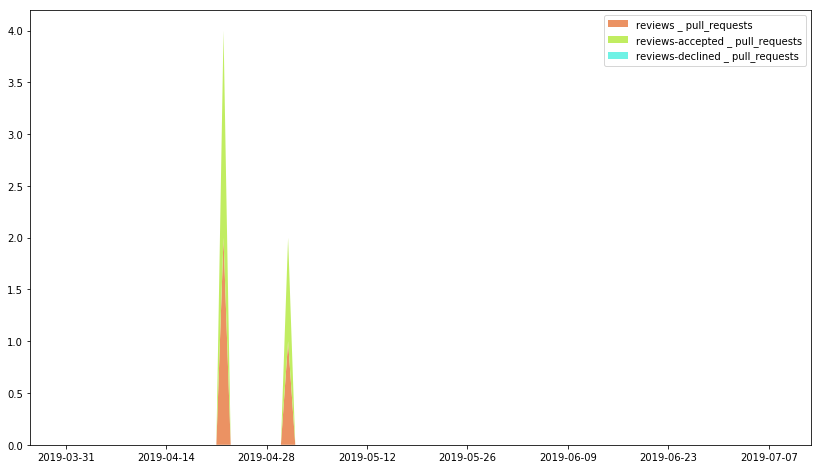

In [80]:
plt.figure(figsize=(14,8))
labels=['reviews _ pull_requests','reviews-accepted _ pull_requests','reviews-declined _ pull_requests']
colors = ['#eb9263','#c1ed61','#6ff2e5']
plt.stackplot(df_frame[:100]['date'].values,df_frame[:100]['reviews _ pull_requests'], df_frame[:100]['reviews-accepted _ pull_requests'],
              df_frame[:100]['reviews-declined _ pull_requests'],labels=labels,colors=colors)
plt.legend()

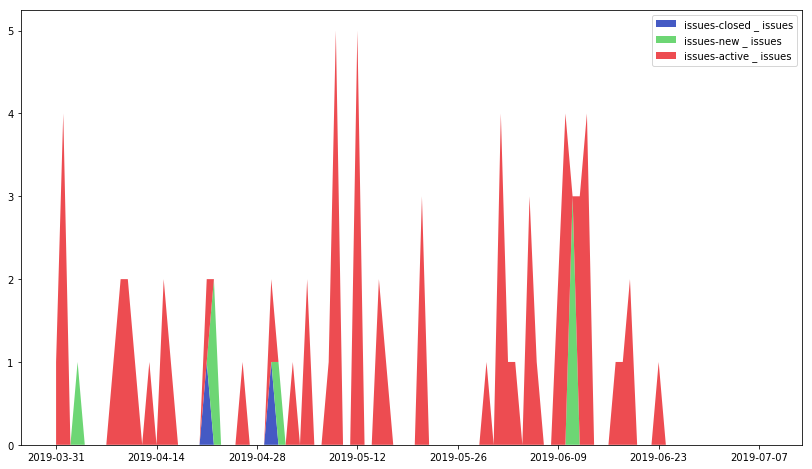

In [81]:
plt.figure(figsize=(14,8))
labels=['issues-closed _ issues','issues-new _ issues','issues-active _ issues']
colors = ['#455ac4','#6dd674','#ed4c51']
plt.stackplot(df_frame[:100]['date'].values,df_frame[:100]['issues-closed _ issues'], df_frame[:100]['issues-active _ issues'],df[:100]['issues-closed _ issues'],
              labels=labels,colors=colors)
plt.legend()

In [82]:
df_frame = df_frame.groupby(df_frame['date']).sum()

In [83]:
df.describe()

,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.534247,30.408219,31.465753,0.383562,0.512329,0.180822,0.060274,0.520548,0.082192,0.041096,0.049315
std,2.251265,211.009428,289.569901,1.404762,1.221594,0.412929,0.270703,1.225973,0.361370,0.535507,0.272918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,17.000000,2688.000000,4595.000000,10.000000,10.000000,2.000000,2.000000,11.000000,3.000000,10.000000,3.000000


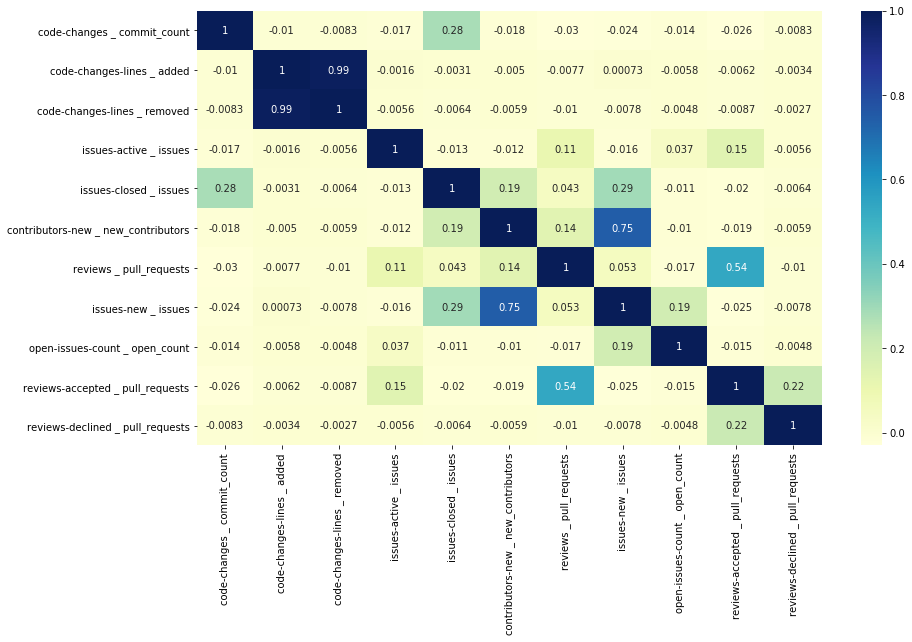

In [84]:
plt.figure(figsize=(14,8))
sns.heatmap(df_frame.corr(), cmap="YlGnBu",annot=True)

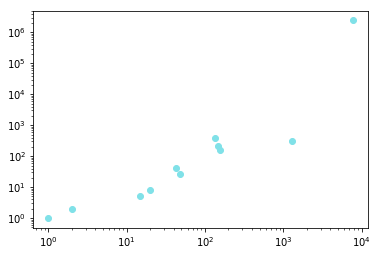

In [87]:
fig,ax=plt.subplots()
labels = ['code-changes-lines _ added','code-changes-lines _ removed']
colors = ['#80e1e8','#8182e6']
ax.plot(df_frame['code-changes-lines _ added'],df_frame['code-changes-lines _ removed'],'o',label=labels,color = '#80e1e8')

ax.set_yscale('log')
ax.set_xscale('log')